# Chronos

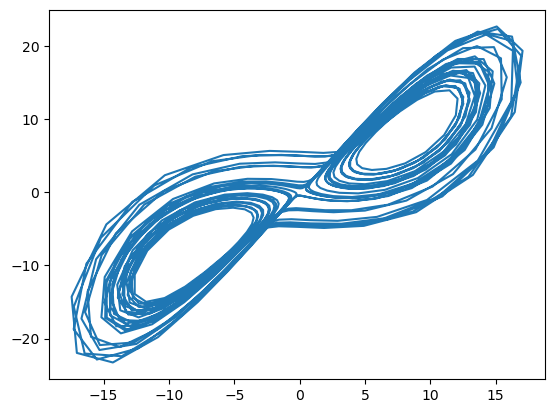

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## Make dataset
from dysts.flows import Lorenz
from dysts.flows import Rossler

#model = Rossler()
#model.ic = np.array([-3.81655523,3.10429694,0.0219432])

model = Lorenz()
# model.ic = np.array([-2.63697978,0.6028729,25.95497073])
#model.ic = np.array([-1.83635088,3.07872907,27.71047215])
# model.ic = np.array([0.0860347,3.67362353,25.42185244])
#model.ic = np.array([-3.57107972,-5.32715247,16.39721569])
#model.ic = np.array([-3.86053107,-0.51336906,26.85695207])
#model.ic = np.array([-1.34211979,1.52646597,24.74616521])
#model.ic = np.array([-5.90069824,-10.5759444,12.28690179])
# model.ic = np.array([-4.79273952,-7.96640585,14.86802532])
#model.ic = np.array([-8.21447797,-15.4514944,11.39810828])
# model.ic = np.array([-2.14483103,-3.75576117,19.53688129])
#model.ic = np.array([-1.93971829,-3.65788245,8.71007293])
#model.ic = np.array([14.36703466,11.87431741,37.24349411])

# traj = model.make_trajectory(1024,
# pts_per_period=30,
# method="Radau",
# atol=1e-12,
# rtol=1e-12)

# traj = model.make_trajectory(1024,
#                             timescale="Lyapunov",
#                             pts_per_period=40,
#                             method="Radau", 
#                             atol=1e-12,
#                             rtol=1e-12)


traj = model.make_trajectory(1024,
                            timescale="Lyapunov",
                            pts_per_period=30,
                            method="Radau", 
                            atol=1e-12,
                            rtol=1e-12)

plt.plot(traj[:,0], traj[:,1])

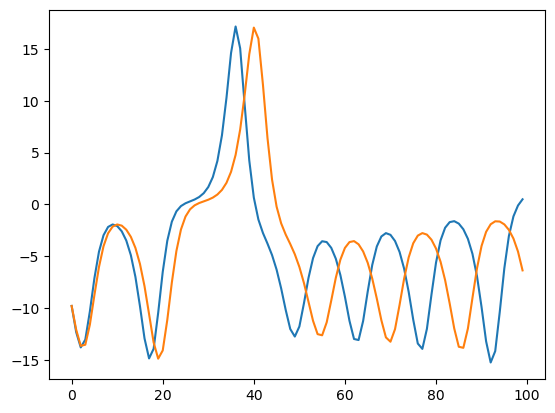

In [12]:
model = Lorenz()

# traj1 = model.make_trajectory(1024,
#     pts_per_period=30,
#     method="Radau",
#     atol=1e-12,
#     rtol=1e-12)
plt.plot(traj1[:100,0])

traj2 = model.make_trajectory(1024,
                            timescale="Lyapunov",
                            pts_per_period=25,
                            method="Radau", 
                            atol=1e-12,
                            rtol=1e-12)

plt.plot(traj2[:100,0])

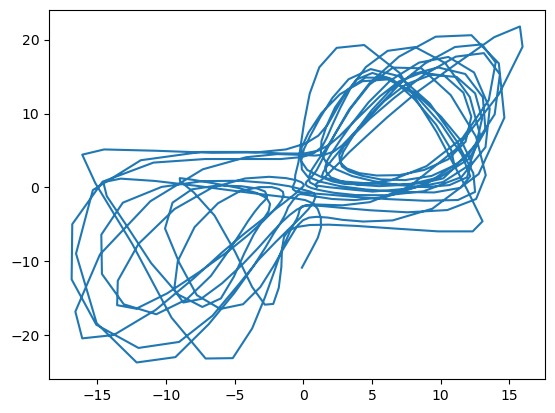

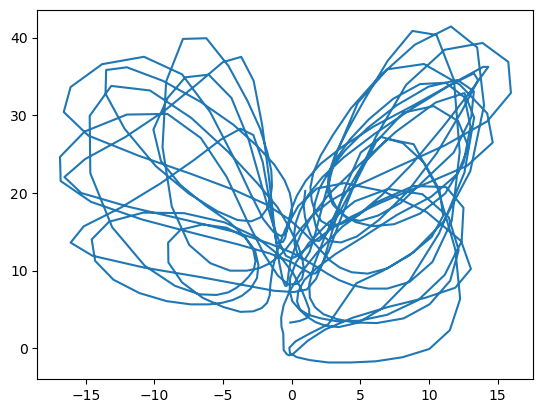

In [6]:
## Load model

import pandas as pd # requires: pip install pandas
import torch
from chronos import ChronosPipeline

# pipeline = ChronosPipeline.from_pretrained(
#     "amazon/chronos-t5-base",
#     device_map="cpu",
#     torch_dtype=torch.bfloat16,
# )


## Set hyperparameters

context_length = 512
current_context_x = np.copy(traj[:context_length, 0])
current_context_y = np.copy(traj[:context_length, 1])
current_context_z = np.copy(traj[:context_length, 2])
forecast_length = 64 # Number of points for model to predict simultaneously
forecast_total_length = 512 # total number of points to forecast
n_average = 2
forecast_agg_x = []
forecast_agg_y = []
forecast_agg_z = []


pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-base",
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )
current_context_xyz = np.array([current_context_x, current_context_y,  current_context_z])
forecast_xyz2 = pipeline.predict(
    context=torch.tensor(current_context_xyz),
    prediction_length=forecast_total_length,
    num_samples=n_average,
    limit_prediction_length=False,
)

plt.figure()
plt.plot(
    np.mean(forecast_xyz2[0, :, :].detach().numpy(), axis=0), 
    np.mean(forecast_xyz2[1, :, :].detach().numpy(), axis=0)
)

plt.figure()
plt.plot(
    np.mean(forecast_xyz2[0, :, :].detach().numpy(), axis=0), 
    np.mean(forecast_xyz2[2, :, :].detach().numpy(), axis=0)
)

has gpu:  False
0 devices found.


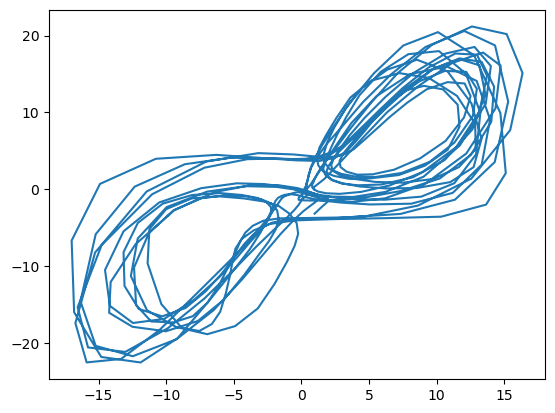

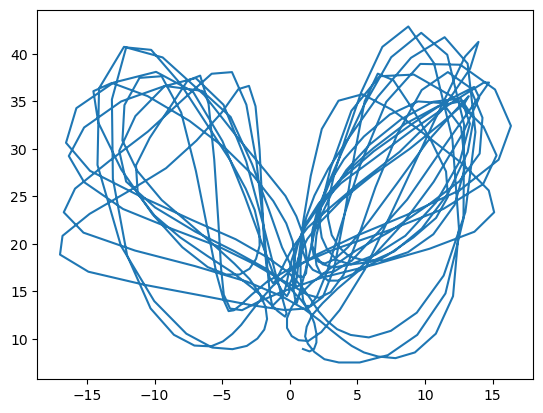

In [7]:
from scripts.models import ChronosModel
model = ChronosModel(model="base", 
                     context=context_length, 
                     n_samples=n_average, 
                     prediction_length=forecast_total_length, 
                     max_chunk=64)

# model = ChronosModel(model=model_size, 
#                      context=context_length, 
#                      n_samples=n_average, 
#                      prediction_length=forecast_length, 
#                      device=device)

forecast_multivariate = np.array(model.predict(current_context_xyz)).squeeze()

plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[0], np.mean(forecast_multivariate, axis=1)[1], label='Forecast')

plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[0], np.mean(forecast_multivariate, axis=1)[2], label='Forecast')

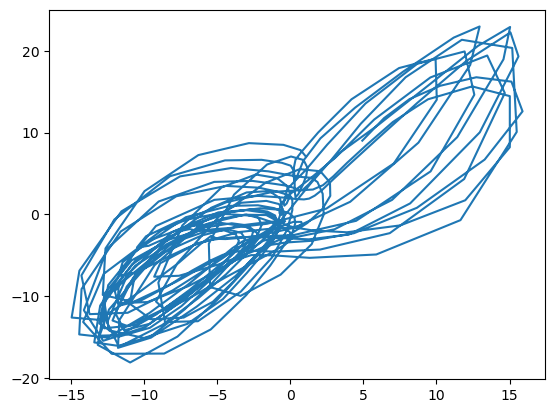

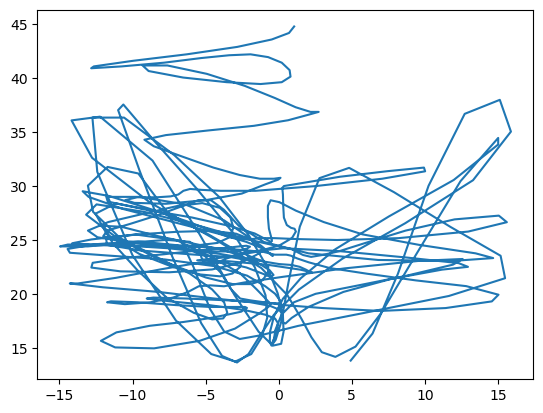

In [5]:
# generate a forecast autoregressively

for i in range(forecast_total_length // forecast_length):

    print(i)
    # pipeline = ChronosPipeline.from_pretrained(
    #     "amazon/chronos-t5-base",
    #     device_map="cpu",
    #     torch_dtype=torch.bfloat16,
    # )
    forecast_x = pipeline.predict(
        context=torch.tensor(current_context_x),
        prediction_length=forecast_length,
        num_samples=n_average,
        limit_prediction_length=False,
        )

    # pipeline = ChronosPipeline.from_pretrained(
    #     "amazon/chronos-t5-base",
    #     device_map="cpu",
    #     torch_dtype=torch.bfloat16,
    # )
    forecast_y = pipeline.predict(
        context=torch.tensor(current_context_y),
        prediction_length=forecast_length,
        num_samples=n_average,
        limit_prediction_length=False,
        )
    
    # pipeline = ChronosPipeline.from_pretrained(
    #     "amazon/chronos-t5-base",
    #     device_map="cpu",
    #     torch_dtype=torch.bfloat16,
    # )
    forecast_z = pipeline.predict(
        context=torch.tensor(current_context_z),
        prediction_length=forecast_length,
        num_samples=n_average,
        limit_prediction_length=False,
        )

    pred_x = np.mean(forecast_x[0, :, :].detach().numpy(), axis=0)
    pred_y = np.mean(forecast_y[0, :, :].detach().numpy(), axis=0)
    pred_z = np.mean(forecast_z[0, :, :].detach().numpy(), axis=0)

    current_context_x = np.append(current_context_x, pred_x)[-context_length:]
    current_context_y = np.append(current_context_y, pred_y)[-context_length:]
    current_context_z = np.append(current_context_z, pred_z)[-context_length:]
    
    forecast_agg_x.append(pred_x.squeeze())
    forecast_agg_y.append(pred_y.squeeze())
    forecast_agg_z.append(pred_z.squeeze())

final_forecast_x = np.hstack(forecast_agg_x)
final_forecast_y = np.hstack(forecast_agg_y)
final_forecast_z = np.hstack(forecast_agg_z)

plt.figure()
plt.plot(final_forecast_x, final_forecast_y, label="forecast")

plt.figure()
plt.plot(final_forecast_x, final_forecast_z, label="forecast")

In [ ]:
plt.plot(final_forecast_x, final_forecast_y, label="forecast")

In [ ]:
plt.plot(final_forecast_x, final_forecast_z, label="forecast")

In [ ]:
plt.plot(final_forecast_x, final_forecast_z, label="forecast")

In [ ]:
plt.plot(final_forecast_x, final_forecast_y, label="forecast")

In [ ]:
## No autoregression

pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-base",
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )

forecast_x2 = pipeline.predict(
    context=torch.tensor(current_context_x),
    prediction_length=forecast_total_length,
    num_samples=n_average,
    limit_prediction_length=False,
)

pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-base",
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )

forecast_y2 = pipeline.predict(
    context=torch.tensor(current_context_y),
    prediction_length=forecast_total_length,
    num_samples=n_average,
    limit_prediction_length=False,
)

pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-base",
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )

forecast_z2 = pipeline.predict(
    context=torch.tensor(current_context_z),
    prediction_length=forecast_total_length,
    num_samples=n_average,
    limit_prediction_length=False,
)

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [ ]:
colors = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]

fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(23,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'$t$, time steps',fontsize = 60)
plt.ylabel(r'$x$',fontsize = 60)

plt.plot(traj[:,0], lw=5, ls='-', color=colors[0], alpha=.5, label="ground truth")
plt.plot(range(context_length,context_length+forecast_total_length),final_forecast_x, lw=5, ls='-', color=colors[1], alpha=1, label="zero-shot forecast")

plt.legend(loc='upper left', frameon=False, prop={'size':45}, ncol=2, bbox_to_anchor=(0, 1.1))
plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
plt.savefig('chronos_lorenz_x.pdf', bbox_inches='tight')

In [ ]:
colors = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]

fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(23,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'$t$, time steps',fontsize = 60)
plt.ylabel(r'$y$',fontsize = 60)

plt.plot(traj[:,1], lw=5, ls='-', color=colors[0], alpha=.5, label="ground truth")
plt.plot(range(context_length,context_length+forecast_total_length),final_forecast_y, lw=5, ls='-', color=colors[1], alpha=1, label="zero-shot forecast")

plt.legend(loc='upper left', frameon=False, prop={'size':45}, ncol=2, bbox_to_anchor=(0, 1.1))

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
plt.savefig('chronos_lorenz_y.pdf', bbox_inches='tight')

In [ ]:
colors = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]

fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(15,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'$x$',fontsize = 60)
plt.ylabel(r'$y$',fontsize = 60)

plt.plot(traj[:,0], traj[:,1], lw=3, ls='-', color=colors[0], alpha=.5, label="ground truth")
plt.plot(final_forecast_x,final_forecast_y, lw=3, ls='-', color=colors[1], alpha=1, label="zero-shot forecast")

plt.legend(loc='upper left', frameon=False, prop={'size':45}, ncol=1)#, bbox_to_anchor=(0, .9))

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
plt.savefig('chronos_lorenz.pdf', bbox_inches='tight')

In [ ]:
print(traj)

In [ ]:
from dysts.analysis import corr_integral, corr_gpdim

print(model.name, corr_integral(traj[:,:2]))
print('Chronos', corr_integral(np.transpose([final_forecast_x,final_forecast_y])))
#print(corr_gpdim(traj1,traj2))